In [167]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data.csv']


### Read Data using pandas

In [168]:
df = pd.read_csv('../input/data.csv')
df.shape

(18207, 89)

In [169]:
df.head(5)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [170]:
drop_cols = ['Unnamed: 0', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Body Type', 'Jersey Number', 'Joined', 'Loaned From', 'Flag', 'Club Logo',
             'Contract Valid Until', 'Photo']
df.drop(drop_cols, axis=1, inplace=True)
df.shape

(18207, 54)

**This dataset contains list of football (soccer) players and their skill ratings taken from FIFA 19 game. We can use these ratings and player attributes to determine what will be their release clause value.**

In [171]:
all_pos = {'RF': 'Forward', 'ST': 'Forward', 'LW': 'Forward', 'GK': 'Goalkeeper', 'RCM': 'Midfielder', 
           'LF': 'Forward', 'RS': 'Forward', 'RCB': 'Defender', 'LCM': 'Midfielder', 'CB': 'Defender',
           'LDM': 'Midfielder', 'CAM':  'Midfielder', 'CDM': 'Midfielder', 'LS': 'Forward', 'LCB': 'Defender', 
           'RM': 'Midfielder', 'LAM': 'Midfielder', 'LM': 'Midfielder', 'LB': 'Defender', 'RDM': 'Midfielder',
           'RW': 'Forward', 'CM': 'Midfielder', 'RB': 'Defender', 'RAM': 'Midfielder', 'CF': 'Forward', 'RWB': 'Defender', 'LWB': 'Defender'}

df['Position_Cat'] = df['Position'].map(all_pos)

**The players generally improve until they age 30 and then they start to decline in overall ratings. This decline is sooner incase of defenders in the age of 31-32**

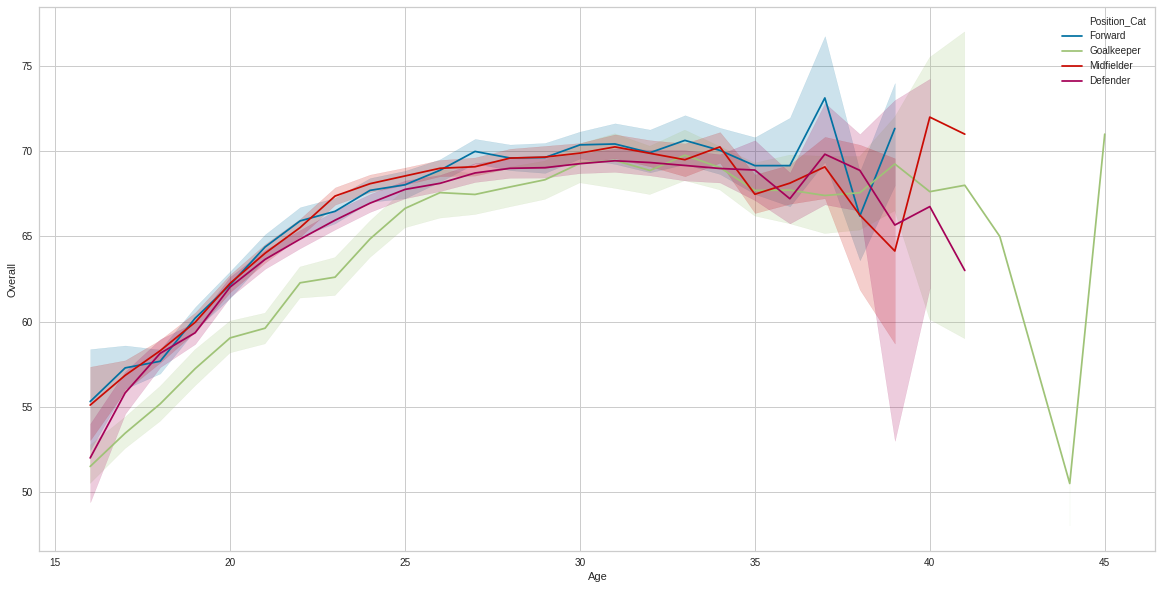

In [172]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x="Age", y="Overall", hue="Position_Cat", data=df, ax=ax);

#### Top Clubs with best players

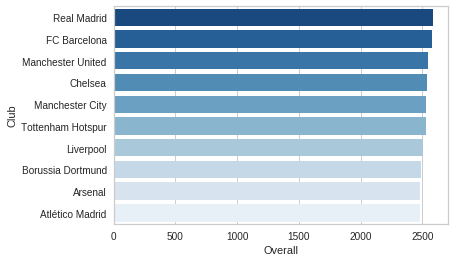

In [173]:
top_clubs = df.groupby(by=['Club'])['Overall'].sum().reset_index().sort_values(by=["Overall"], ascending=False).head(10)
sns.barplot(y='Club', x='Overall', data=top_clubs, palette=sns.color_palette("Blues_r", 10));

#### Clearly, major clubs like AS Monaco and Athletico Madrid are playing under their potential

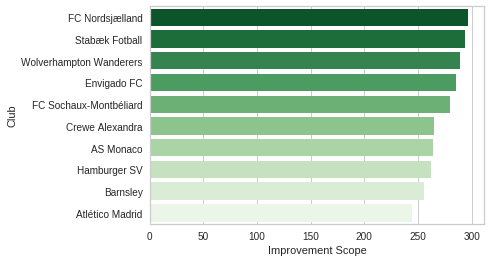

In [174]:
df['Improvement Scope'] = df['Potential'] - df['Overall']
top_clubs_to_improve = df.groupby(by=['Club'])['Improvement Scope'].sum().reset_index().\
sort_values(by=["Improvement Scope"], ascending=False).head(10)
sns.barplot(y='Club', x='Improvement Scope', data=top_clubs_to_improve, palette=sns.color_palette("Greens_r", 10));

#### Country Comparison if top 30 players from each country are considered

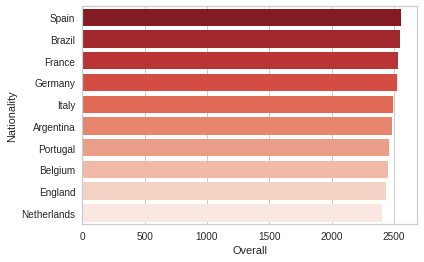

In [175]:
top_30_df = df.iloc[df.groupby('Nationality')['Overall'].nlargest(30).reset_index()['level_1']]
top_nations = top_30_df.groupby(by=['Nationality'])['Overall'].sum().reset_index().sort_values(by=["Overall"], ascending=False).head(10)
sns.barplot(y='Nationality', x='Overall', data=top_nations, palette=sns.color_palette("Reds_r", 10));

### Data Pre-Processing and Feature Engineering

### Handling Missing Values
Below columns have missing values

In [176]:
null_counts_df = df.isnull().sum().to_frame(name="null counts")
null_counts_df[null_counts_df["null counts"] > 0].index

Index(['Club', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Real Face', 'Position', 'Height', 'Weight',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause', 'Position_Cat'],
      dtype='object')

In [177]:
df = df[df['Position'].notnull()]
# Assign club as 'Other' for players having no club assigned here
df['Club'].fillna('Other', inplace=True)

# Assign most common value of preferred foot to the player where this feature is null
df['Preferred Foot'].fillna(df['Preferred Foot'].mode(), inplace=True)
df['Weak Foot'].fillna(df['Weak Foot'].mode(), inplace=True)

df['Skill Moves'].fillna(df['Skill Moves'].median(), inplace=True)
df['Work Rate'].fillna(df['Work Rate'].mode(), inplace=True)
df['International Reputation'].fillna(df['International Reputation'].median(), inplace=True)
df['Height'].fillna(df['Height'].mode(), inplace=True)
df['Weight'].fillna(df['Weight'].mode(), inplace=True)

### Bin Continuous Variables
We shall bin continuous variables like Age because in football the age range of a player decides the release clause value. The absolute value of the age does not offer much addditional value to the football club buying the player. Similarly, our model should work on the binned variable for the age rather than the continuous feature provided here.

,Age_Quantile_label,Age_Range
0,Age75-100Q,"(28.0, 45.0]"
2,Age50-75Q,"(25.0, 28.0]"
9,Age25-50Q,"(21.0, 25.0]"
25,Age0-25Q,"(15.999, 21.0]"


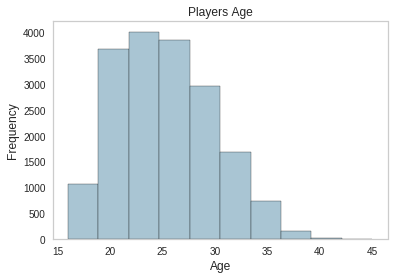

In [178]:
def histogram(col_name, title, xlabel):
    fig, ax = plt.subplots()
    df[col_name].hist(color='#A9C5D3', edgecolor='black', grid=False)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
histogram('Age', 'Players Age', 'Age');
def cut_quantile(quant_col_name, quant_col_label, col_to_cut):
    quantile_list = [0, 0.25, 0.5, 0.75, 1.0]
    quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
    quantile_labels = [col_to_cut + s for s in quantile_labels]
    df[quant_col_name] = pd.qcut(df[col_to_cut], q=quantile_list)
    df[quant_col_label] = pd.qcut(df[col_to_cut], q=quantile_list, labels=quantile_labels)
cut_quantile('Age_Range', 'Age_Quantile_label', 'Age')
df[['Age_Quantile_label', 'Age_Range']].drop_duplicates()

In the above table, we can see that we have binned age to different range values. For example, age between 16 to 21 is binned in the first quartile (0-25Q) and players aged above 28 are binned in last quartile (75-100Q)**

#### Parse Value and Wage columns

In [179]:
df['Value_in_millions'] = df['Value'].apply(lambda x: float(x[1:-1])/1000 if (x[-1] == 'K' and x[1] != '0') else (0.001 if x [-1] == '0' else float(x[1:-1])))
df['Wage_in_K'] = df['Wage'].apply(lambda x: float(x[1:-1]) if x[1] != '0' else 0.001)
df[['Name', 'Value', 'Value_in_millions', 'Wage', 'Wage_in_K']].sample(5)

,Name,Value,Value_in_millions,Wage,Wage_in_K
11386,C. Agnelli,€350K,0.350,€1K,1.0
17297,C. Ruiz,€120K,0.120,€1K,1.0
10716,L. Miracoli,€675K,0.675,€2K,2.0
7297,J. Ahlmann,€825K,0.825,€6K,6.0
16540,A. Attiah,€160K,0.160,€2K,2.0


### Age vs Value
**Players in age range of 25-28 are of highest value**

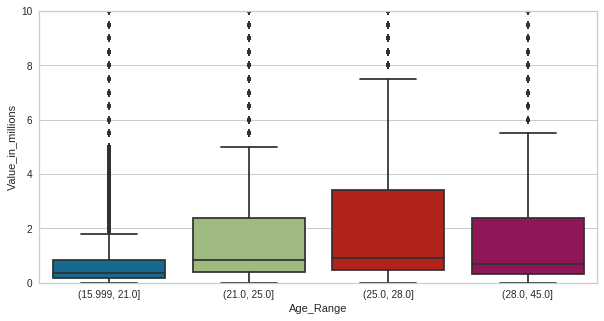

In [180]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set(ylim=(0, 10))
sns.boxplot(x="Age_Range", y="Value_in_millions", data=df, ax=ax);

### Position vs Value
**Forwards and midfielders cost most while goalkeepers are the cheapest**

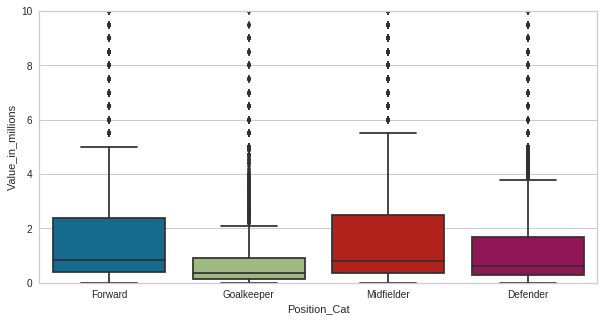

In [181]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set(ylim=(0, 10))
sns.boxplot(x="Position_Cat", y="Value_in_millions", data=df, ax=ax);

### Ratings vs Value
**Value increases as the overall rating of the player increase**

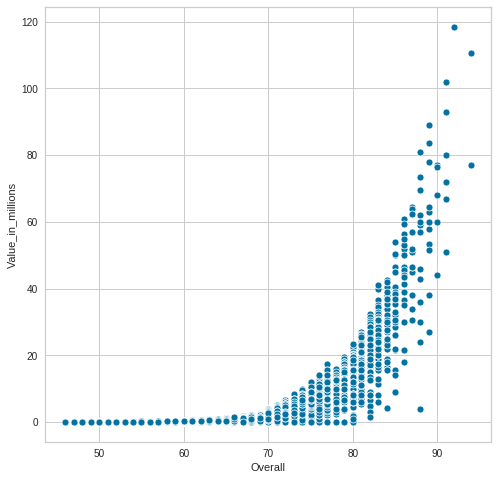

In [182]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x="Overall", y="Value_in_millions", data=df, ax=ax);

### Property Analysis of Players of Different Positions
1. Centre Backs are strong and good jumpers
2. Wing Backs and left flank defenders are agile
3. Tackle ability of defenders is highest
4. Attacking midfielders like CAM, RAM, LAM, LM and RM are more agile and have higher sprint speeds than other midfield players
5. Short Passing ability of midfielders is highest
6. Forwards are most agile players with higher balance and reactions

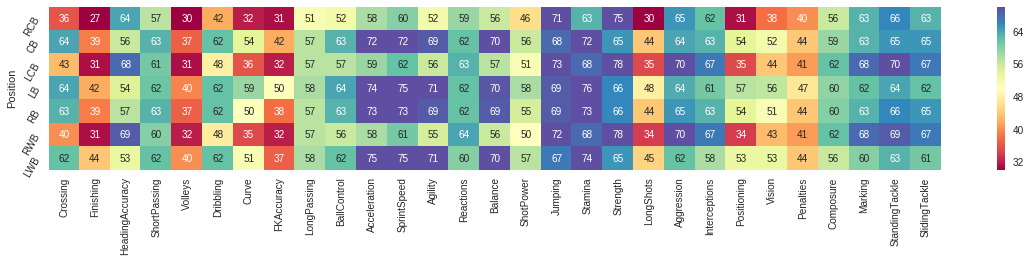

In [183]:
fig, ax = plt.subplots(figsize=(20, 3))
mean_attributes_by_pos_df = df[df['Position_Cat'] == "Defender"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()
g = sns.heatmap(mean_attributes_by_pos_df, cmap="Spectral", ax=ax, vmax=70, vmin=30, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Defender"]["Position"].unique().tolist(), rotation=60);

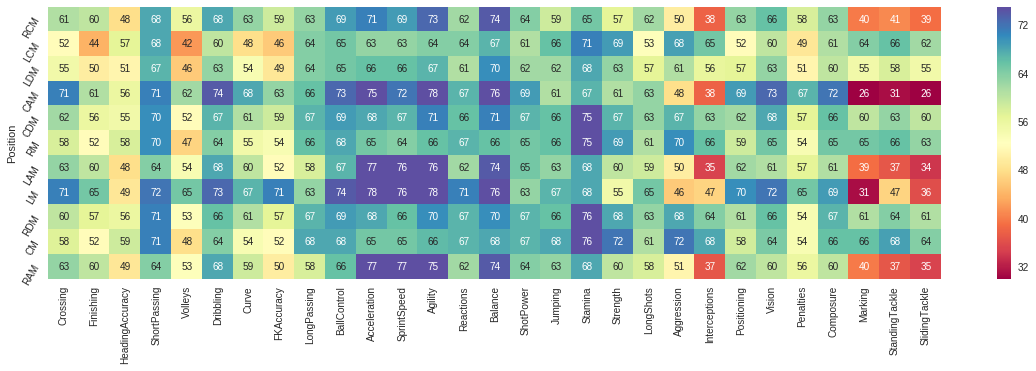

In [184]:
fig, ax = plt.subplots(figsize=(20, 5))
mean_attributes_by_pos_df = df[df['Position_Cat'] == "Midfielder"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()
g = sns.heatmap(mean_attributes_by_pos_df, cmap="Spectral", ax=ax, vmax=75, vmin=30, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Midfielder"]["Position"].unique().tolist(), rotation=60);

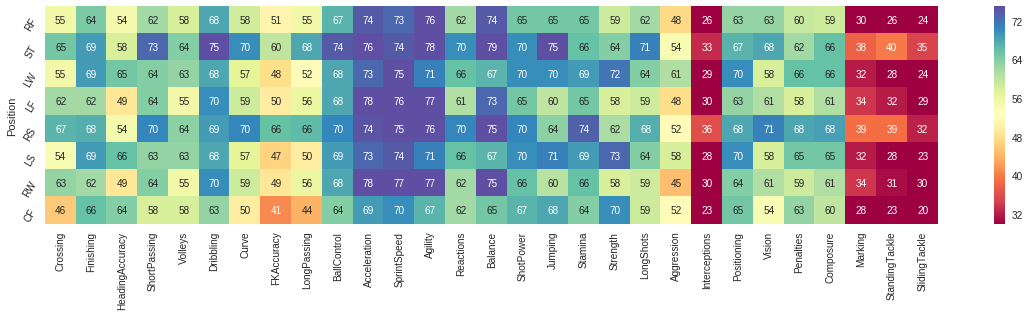

In [185]:
fig, ax = plt.subplots(figsize=(20, 4))
mean_attributes_by_pos_df = df[df['Position_Cat'] == "Forward"].groupby("Position")[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].median()
g = sns.heatmap(mean_attributes_by_pos_df, cmap="Spectral", ax=ax, vmax=75, vmin=30, annot=True)
g.set_yticklabels(labels=df[df['Position_Cat'] == "Forward"]["Position"].unique().tolist(), rotation=60);

### Players which can grow most
> Players like S. Gimenez, B. Kavanagh, J. Van Moos are not expensive and have great potential to grow

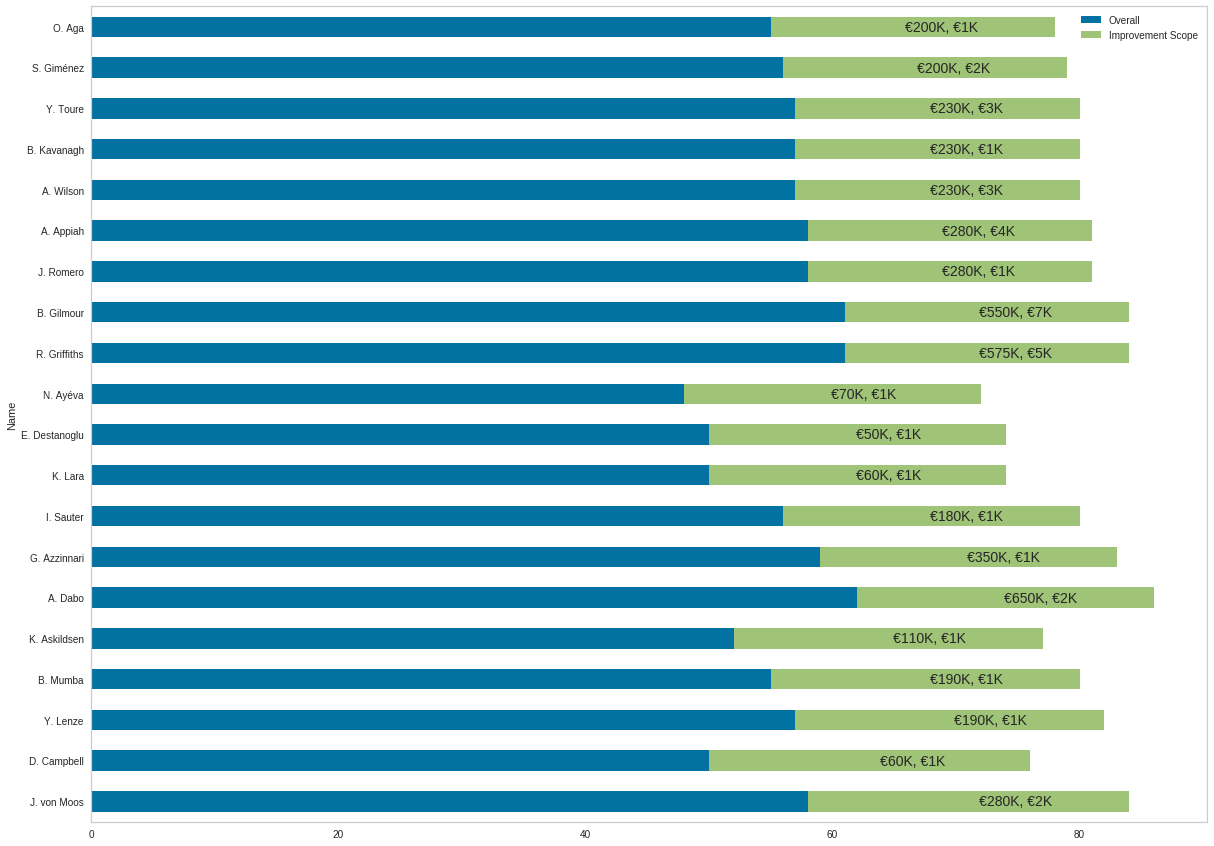

In [186]:
fig, ax = plt.subplots(figsize=(20, 15))
sub_df = df.loc[df['Improvement Scope'].nlargest(20).reset_index()['index']][['Name', 'Overall', 'Improvement Scope']]
values = df.loc[df['Improvement Scope'].nlargest(20).reset_index()['index']]['Value'].tolist()
wages = df.loc[df['Improvement Scope'].nlargest(20).reset_index()['index']]['Wage'].tolist()
sub_df.set_index('Name').plot(kind='barh', stacked=True, ax=ax, grid=False)
i = 0
for p in ax.patches:
    if i > 19:
        ax.annotate(str(values[i-20]) + ', ' + str(wages[i-20]), (p.get_x() + p.get_width(), p.get_y()), \
                    xytext=(-150, 6), textcoords='offset points', size=14)
    i = i + 1

### Team Building for any Budget
#### **4-3-3 = GK, LCB, RCB, LB, RB, LCM, CM, RCM, LW, RW, ST**

In [187]:
pos_4_3_3_dict = {'GK': ['GK'], 'LCB': ['CB', 'LCB'], 'RCB': ['CB', 'RCB'], 'LB': ['LB', 'LWB'], 'RB': ['RB', 'RWB'], 
'CM': ['CM', 'CDM'], 'LCM': ['LCM', 'CAM'], 'RCM': ['RCM', 'CAM'], 'RW': ['RW', 'RM', 'RAM', 'RF'], 'LW': ['LW', 'LAM', 'LM', 'LF'], 
'ST': ['ST', 'CF', 'RS', 'LS']}

In [188]:
pos_value_df = df.groupby(['Position'])['Value_in_millions'].sum().reset_index()
pos_4_3_3_df = pos_value_df[pos_value_df['Position'].isin(pos_4_3_3_dict.keys())]
pos_4_3_3_counts = df[df['Position'].isin(pos_4_3_3_dict.keys())]['Position'].value_counts()
pos_4_3_3_df['Counts'] = pos_4_3_3_df['Position'].apply(lambda x: pos_4_3_3_counts[x])
pos_4_3_3_df['Value_in_millions'] = pos_4_3_3_df['Value_in_millions']/pos_4_3_3_df['Counts']
pos_4_3_3_sum = pos_4_3_3_df['Value_in_millions'].sum()
pos_4_3_3_df['Ratio'] = pos_4_3_3_df['Value_in_millions'].apply(lambda x: round(x/pos_4_3_3_sum, 2))
pos_4_3_3_df = pos_4_3_3_df.set_index('Position')
pos_4_3_3_df.drop(['Counts'], axis=1)

,Value_in_millions,Ratio
Position,,
CM,1.966468,0.06
GK,1.585833,0.05
LB,1.718300,0.06
LCB,3.010414,0.10
LCM,4.265003,0.14
LW,3.451659,0.11
RB,1.688058,0.05
RCB,3.046073,0.10
RCM,4.123488,0.13


**So for about \$100 spent on team, following is the value distribution for each position **
1. GK = \$5
2. LCB = \$10
3. RCB = \$10
4. LB = \$6
5. RB = \$5
6. CM = \$6
7. LCM = \$14
8. RCM = \$13
9. LW = \$11
10. RW = \$12
11. ST = \$8

Let us build a club for which we have input value constraint given in below input slider

In [189]:
# callback function for our widget
def f(x):
    budget = x
    player_running_l = []
    for pos in pos_4_3_3_dict.keys():
        sub_df = df[(df['Position'].isin(pos_4_3_3_dict[pos])) & ~(df['Name'].isin(player_running_l)) & \
                  (df['Value_in_millions'] <= pos_4_3_3_df.loc[pos, 'Ratio'] * budget)]
        
        overall = sub_df['Overall'].max()
        name = sub_df.loc[sub_df[(sub_df['Overall'] == overall)]['Value_in_millions'].argmin()]['Name']
        
        pos_4_3_3_df.loc[pos, 'Player'] = name
        pos_4_3_3_df.loc[pos, 'Overall'] = overall
        player_running_l.append(name)

    display(pos_4_3_3_df.reindex(pos_4_3_3_dict.keys())[['Player', 'Overall']])
    
interact(f, x=widgets.IntSlider(min=10,max=1500,step=10,value=10));

interactive(children=(IntSlider(value=10, description='x', max=1500, min=10, step=10), Output()), _dom_classes…

### Best Players in different arts of soccer

In [190]:
niche_cols = ['Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

feature_list = []
for col in niche_cols:
    feature_list.append(["Best " + col, df.iloc[df[col].idxmax]["Name"]])
    
niche_players = pd.DataFrame(feature_list, columns=["Feature", "Player"])
niche_players.set_index('Feature')

,Player
Feature,
Best Overall,L. Messi
Best Potential,K. Mbappé
Best Crossing,K. De Bruyne
Best Finishing,L. Messi
Best HeadingAccuracy,Naldo
Best ShortPassing,L. Modrić
Best Volleys,E. Cavani
Best Dribbling,L. Messi
Best Curve,Quaresma


### Preparing for the Linear Regression Model to predict Overall Rating from niche features of players

In [191]:
major_nations = ['Belgium','France','Brazil','England','Croatia','Uruguay','Portugal','Switzerland','Spain','Denmark',
                 'Argentina','Colombia','Germany','Sweden','Chile','Netherland','Italy','Mexico','Wale','Poland']

df["Major Nation"] = df["Nationality"].apply(lambda x: 1 if x in major_nations else 0)

#### Skeweness in the Value and Wages of the players, lets transform it through boxcox transformation

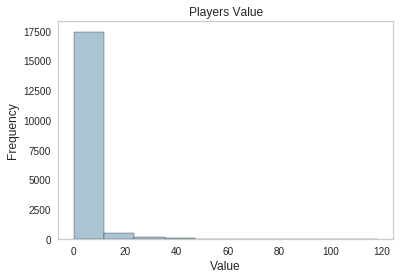

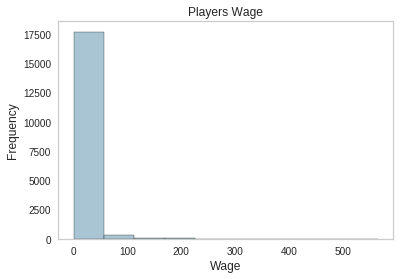

In [192]:
histogram('Value_in_millions', 'Players Value', 'Value');
histogram('Wage_in_K', 'Players Wage', 'Wage');

In [193]:
df['Value_in_millions'] = boxcox(df['Value_in_millions'])[0]
df['Wage_in_K'] = boxcox(df['Wage_in_K'])[0]

#### Deriving BMI Index of a player

In [194]:
df['Weight'] = df['Weight'].apply(lambda x: int(x.replace("lbs", "")))
df['Height'] = df['Height'].apply(lambda x: (int(x[0]) * 12 + int(x[x.find("'") + 1:])) * 2.54 * 0.393701)
df['BMI'] = df['Weight'] * 703 /(df['Height'] * df['Height'])
df['BMI Index'] = np.where(df['BMI'] < 18.5, 'underweight', np.where(df['BMI'] < 25, 'normal', np.where(df['BMI'] < 30, 'overweight', 'obese')))

#### Scaling the work rate of a player

In [195]:
work_rate_dict = {'Medium/ Medium': 4, 'High/ Low': 4, 'High/ Medium': 6, 'High/ High': 9,
       'Medium/ High': 6, 'Medium/ Low': 2, 'Low/ High': 4, 'Low/ Medium': 2,
       'Low/ Low': 1}
df['Work Rate'] = df['Work Rate'].map(work_rate_dict)

In [196]:
refined_df = df.drop(['Nationality', 'Club', 'Age', 'Real Face', 'Value', 'Wage', 'Special', 
                      'Potential', 'Age_Range', 'Release Clause', 'Height', 'Weight', 'BMI'], axis=1)
refined_df.head(5)

,ID,Name,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Position_Cat,Improvement Scope,Age_Quantile_label,Value_in_millions,Wage_in_K,Major Nation,BMI Index
0,158023,L. Messi,94,Left,5.0,4.0,4.0,4,RF,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,Forward,0,Age75-100Q,5.527087,9.069155,1,normal
1,20801,Cristiano Ronaldo,94,Right,5.0,4.0,5.0,4,ST,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Forward,0,Age75-100Q,5.038608,8.424358,1,normal
2,190871,Neymar Jr,92,Right,5.0,5.0,5.0,6,LW,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Forward,1,Age50-75Q,5.622979,7.800190,1,normal
3,193080,De Gea,91,Right,4.0,3.0,1.0,4,GK,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,Goalkeeper,2,Age50-75Q,4.949103,7.600923,1,normal
4,192985,K. De Bruyne,91,Right,4.0,5.0,4.0,9,RCM,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,Midfielder,1,Age50-75Q,5.417825,8.175446,1,normal


In [199]:
id_list = refined_df['ID']
names = refined_df['Name']
target = refined_df['Overall']
model_df = refined_df.drop(['ID', 'Name', 'Overall', 'Position', 'Improvement Scope'], axis=1)
model_df = pd.get_dummies(model_df)
model_df.shape

(18147, 55)

#### Use Linear Regression Model to generate Residuals Plot and calculate RMSE and R2 metrics

In [200]:
def analyse_model(model):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("RMSE train data is %s" % math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("RMSE test data is %s" % math.sqrt(mean_squared_error(y_test, y_test_pred)))
    coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])  
    print(coeff_df.describe())
    
    return y_test_pred

In [201]:
X_train, X_test, y_train, y_test = train_test_split(model_df, target, test_size=0.20, random_state=42)

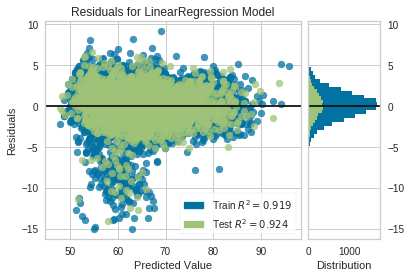

RMSE train data is 1.968897243650014
RMSE test data is 1.8810121648565559
       Coefficient
count    55.000000
mean      0.075290
std       0.467166
min      -1.415961
25%      -0.004307
50%       0.011150
75%       0.060890
max       1.915213


In [202]:
linear_regr_model = LinearRegression()
predictions = analyse_model(linear_regr_model)

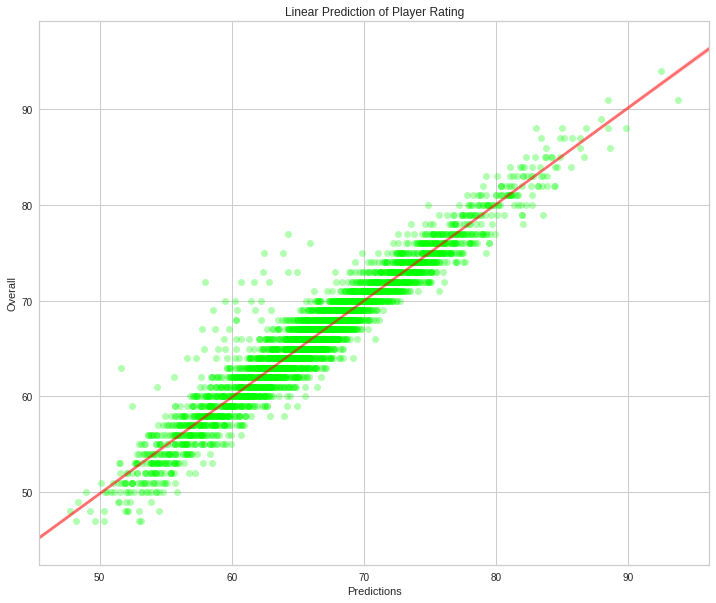

In [203]:
plt.figure(figsize=(12,10))
sns.regplot(predictions, y_test,scatter_kws={'alpha':0.3,'color':'lime'},line_kws={'color':'red','alpha':0.5})
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

#### As we can see above that linear regression model fits both test and train data well with R2 metric over 91% and RMSE less than 2 rating points. Also, the residual plot has mostly normal distribution with homogenity embedded

### Use Clustering to identify similar players

In [213]:
new_df = refined_df[['Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']]
new_df.head(5)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


#### Use Gaussian Mixture Model for clustering

In [214]:
from sklearn.preprocessing import StandardScaler
new_df_std = StandardScaler().fit_transform(new_df)
from sklearn.mixture import GaussianMixture
gmm_model = GaussianMixture(n_components=4).fit(new_df_std)
gmm_model.predict(new_df_std)
df['cluster'] = gmm_model.predict(new_df_std)

#### Select a player and get 10 similar players

In [229]:
def f(x):
    cluster = df[df['Name'] == x]['cluster'].item()
    display(df[df['cluster'] == cluster][['Name', 'Age', 'Position', 'Club', 'Value', 'Wage', 'Overall']].head(10))

all_players = df['Name'].unique().tolist()
interact(f, x=widgets.Dropdown(options=all_players, value='L. Messi', description='Player:', disabled=False));

interactive(children=(Dropdown(description='Player:', options=('L. Messi', 'Cristiano Ronaldo', 'Neymar Jr', '…